In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import cartopy.feature as feature
import cartopy.crs as ccrs
from cartopy.io import shapereader

import iris
import iris.analysis.cartography
import iris.quickplot as qplt
import iris.plot as iplt
#from ctd import plot_section
from oceans.colormaps import cm
from oceans.colormaps import cm as ocncm
from mpl_toolkits.basemap import cm as bmcm
from matplotlib.colors import LinearSegmentedColormap as LSC

from iris.coords import DimCoord

import numpy as np

from netCDF4 import Dataset
#gridline stuff
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats.stats import pearsonr   

import scipy.ndimage as ndimage


import xray
import dask

#import gdal
import shapely

# these may be of use
#May need to create a link in ~/anaconda2/lib
#-> ln -s libgeos-3.5.0.so libgeos-3.4.2.so
import ogr, gdal, osr, os

import numpy as np
import itertools
from math import sqrt,ceil
from skimage import feature as skfeature


%matplotlib inline

In [2]:
datadir="./"

In [3]:
lm = xray.open_dataset(datadir+'/landfrac.nc')
ts = xray.open_dataset(datadir+'/TS.nc')

/home/guido/anaconda2/lib/python2.7/site-packages/xarray/conventions.py:382: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


In [4]:
print lm.coords
print ts.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * time     (time) object 4505-01-16 05:17:35
  * nbnd     (nbnd) int64 0 1
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 -86.23 -85.29 -84.35 ...
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 6.25 7.5 8.75 10.0 11.25 ...
  * time     (time) object 4505-01-16 05:17:35
  * nbnd     (nbnd) int64 0 1


/home/guido/anaconda2/lib/python2.7/site-packages/xarray/conventions.py:401: RuntimeWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


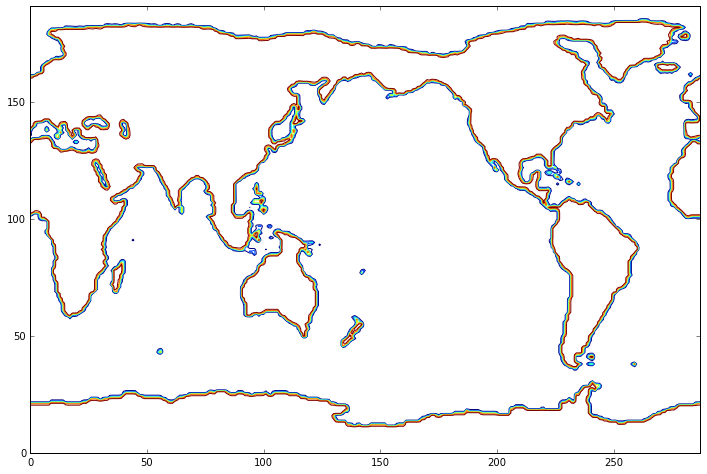

In [5]:
fig=plt.figure(figsize=(12,8))
ax=plt.subplot(111)
ax.contour(lm['LANDFRAC'].data[0,:,:])

/home/guido/anaconda2/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


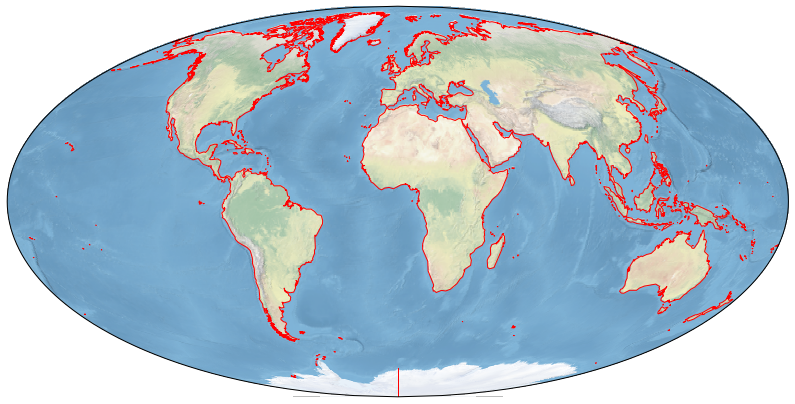

In [6]:
fig = plt.figure(facecolor='white', figsize = (14,10))

ax = plt.axes(projection=ccrs.Mollweide())

ax.stock_img()
# Draw coastlines.
ax.add_feature(feature.GSHHSFeature('coarse', edgecolor='red'))


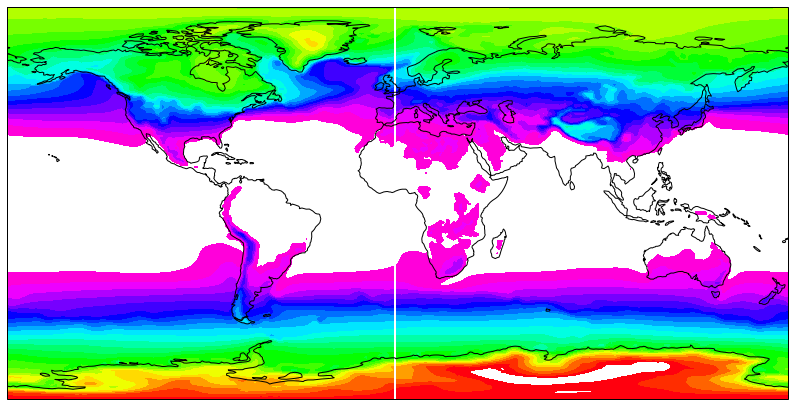

In [7]:
# Using cartopy Natural Earth
fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Mollweide())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(210.,290., 25)

projlons=ts.coords['lon'].data
projlats=ts.coords['lat'].data
#cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
#                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap)

# Add coastlines to the map created by contourf. (Natural earth website not reachable ???)
plt.gca().coastlines()


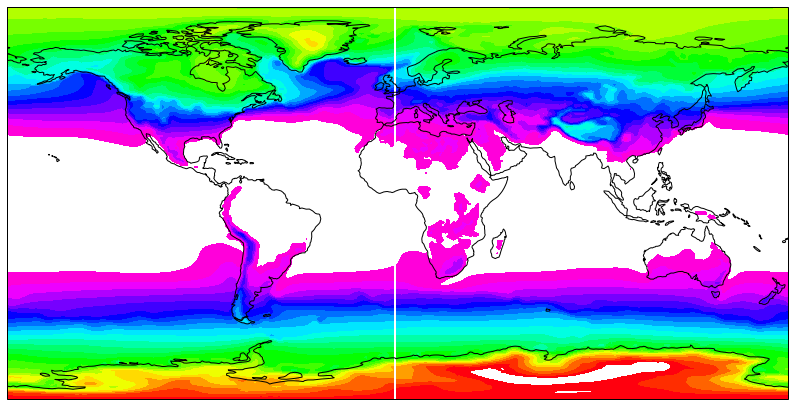

In [8]:
# using cartopy shapereader 

fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Mollweide())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(210.,290., 25)

projlons=ts.coords['lon'].data
projlats=ts.coords['lat'].data
#cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
#                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap)


ax.add_geometries(list(shapereader.Reader("ne_110m_coastline.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 

In [9]:
## Create a raster from a numpy array

def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Byte)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(4326)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()


def a2r(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array):
    reversed_arr = array[::-1] # reverse array so the tif looks like the array
    array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,reversed_arr) # convert array to raster

In [10]:
rasterOrigin = (0,0)
pixelWidth = 10
pixelHeight = 10
newRasterfn = 'test.tif'
# this array is the word "GDAL"
array = np.array([[ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [ 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
                      [ 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
                      [ 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
                      [ 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1],
                      [ 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1],
                      [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [ 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

a2r(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array)


In [11]:
# rm test.*
# gdal_polygonize.py test.tif -f "ESRI Shapefile" test.shp

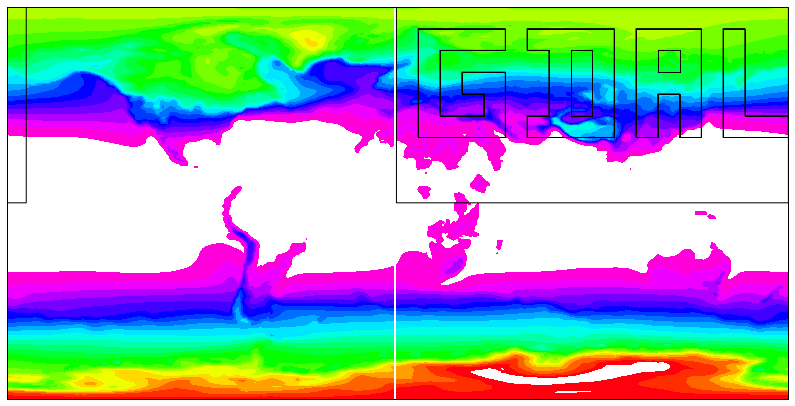

In [12]:
# using gdal_polygonize.py

fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Mollweide())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(210.,290., 25)

projlons=ts.coords['lon'].data
projlats=ts.coords['lat'].data
#cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
#                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap)



ax.add_geometries(list(shapereader.Reader("test.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 


In [13]:
# this doesn't seem to work (install gdal_polygonize and execute in shell)

# \rm lgm.*
# gdal_polygonize.py lgm_raster.tif -f "ESRI Shapefile" lgm.shp

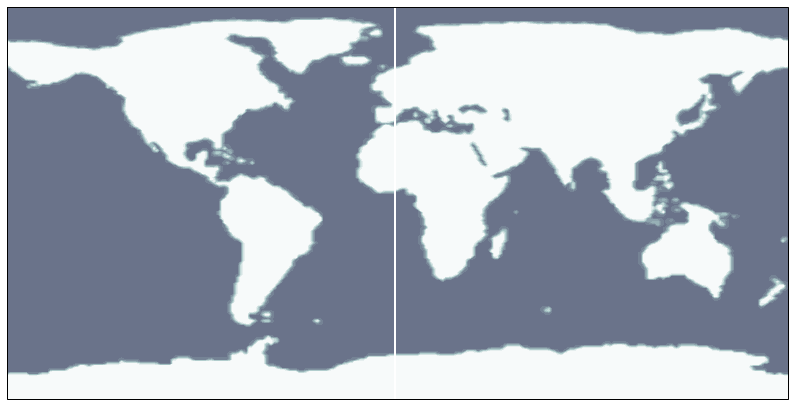

In [14]:
# make a raster file from the LGM landfrac
fig = plt.figure(facecolor='white', figsize = (14,10),frameon=False)

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
#colormap = matplotlib.cm.gist_rainbow
colormap = matplotlib.cm.bone

contour_levels = np.linspace(-1, 1, 21)

projlons=lm.coords['lon'].data
projlats=lm.coords['lat'].data
cubedata=lm['LANDFRAC'].data[0,:,:].copy()
#cubedata[~ np.isnan(cubedata)] = 1
#cubedata[np.isnan(cubedata)] = 0
cntsplot=ax.contourf(projlons,projlats,cubedata,contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')

ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

saveplot=True
if saveplot:
    figname='lgm_raster'
    #plt.savefig(figname+".png", dpi=300, bbox_inches='tight')
    #plt.savefig(figname+".pdf",bbox_inches='tight')
    plt.savefig(figname+".tif", dpi=300,bbox_inches='tight')


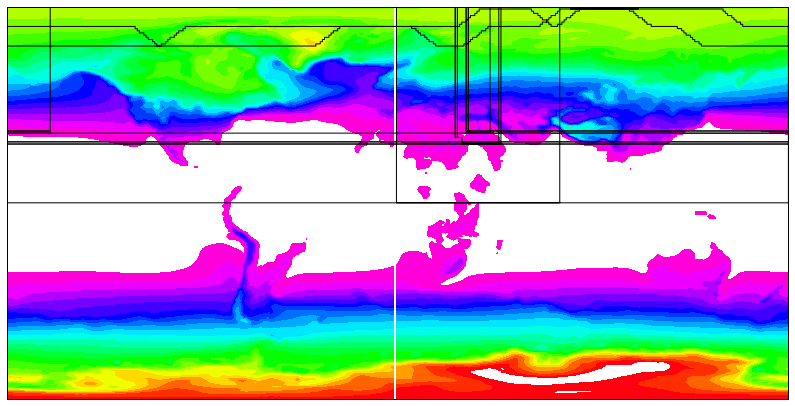

In [15]:
# using gdal_polygonize.py

fig = plt.figure(facecolor='white', figsize = (14,10))

#ax=plt.subplot(111)
ax = plt.axes(projection=ccrs.PlateCarree())
#ax = plt.axes(projection=ccrs.Mollweide())
colormap = matplotlib.cm.gist_rainbow

contour_levels = np.linspace(210.,290., 25)

projlons=ts.coords['lon'].data
projlats=ts.coords['lat'].data
#cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
#                     transform=ccrs.PlateCarree(),cmap=colormap,extend='both')
cntsplot=ax.contourf(projlons,projlats,ts['TS'].data[0,:,:],contour_levels,
                     transform=ccrs.PlateCarree(),cmap=colormap)



ax.add_geometries(list(shapereader.Reader("lgm.shp").geometries()), ccrs.PlateCarree(),facecolor='none') 


## more work to be done